In [1]:
import pandas as pd
import datetime as dt
import re
import seaborn as sns
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

Загрузим dataset и воспользуемся функциями describe(), info(), head() для того, чтобы познакомиться с данными.

In [2]:
data = pd.read_csv('aac_shelter_outcomes.csv')

In [3]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
data.shape

(78256, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [6]:
data.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [7]:
data.describe(include = 'object')

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A706536,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


Наблюдения:
1. Все переменные - категориальные. Не порядок. Нужно это исправить при необходимости.
2. В 5 столбцах:
    * age_upon_outcome;
    * name;
    * outcome_subtype;
    * outcome_type;
    * sex_upon_outcome   
присутсвуют пропущенные значения. Нужно решить, что с ними делать.
3. Переменная "monthyear" совпадает с переменной "datetime". Следует удалить "monthyear".
4. Переменная "age_upon_outcome" получается из разности переменных "datetime" и "date_of_birth", следовательно, ее можно удалить (тем более, там еще и пропуски...фи, какая нехорошая переменная).

Удалим дубликаты:

In [8]:
data.drop_duplicates(subset = ['animal_id','datetime'], inplace = True)

In [9]:
data.shape

(78246, 12)

In [10]:
data.animal_type.value_counts()

Dog          44240
Cat          29415
Other         4248
Bird           334
Livestock        9
Name: animal_type, dtype: int64

Домашнего скота не так много, поэтому удалим эти строки из набора.

In [11]:
data = data[data.animal_type != 'Livestock']

In [12]:
data = data.reset_index()

Создадим новые переменные из переменных "date_of_birth" и "datetime".

In [13]:
def get_date(var):
    return dt.datetime.strptime(var[:10], '%Y-%m-%d').date()  

In [14]:
data['birth_date'] = data['date_of_birth'].apply(get_date)

In [15]:
data['outcome_date'] = data['datetime'].apply(get_date)

In [16]:
data.head(3)

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date
0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2014-07-07,2014-07-22
1,1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07
2,2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,2013-03-31,2014-06-03


Странно, что id животных повторяются, посмотрим на них

In [17]:
data.animal_id.value_counts().reset_index().head()

,index,animal_id
0,A718223,11
1,A706536,11
2,A721033,10
3,A716018,8
4,A616444,8


In [18]:
data[data.animal_id == 'A006100']

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date
6965,6968,6 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,2007-07-09T00:00:00,2014-03-08T17:10:00,2014-03-08T17:10:00,Scamp,NaN,Return to Owner,Neutered Male,2007-07-09,2014-03-08
7052,7055,7 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,2007-07-09T00:00:00,2014-12-20T16:35:00,2014-12-20T16:35:00,Scamp,NaN,Return to Owner,Neutered Male,2007-07-09,2014-12-20
73471,73490,10 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,2007-07-09T00:00:00,2017-12-07T00:00:00,2017-12-07T00:00:00,Scamp,NaN,Return to Owner,Neutered Male,2007-07-09,2017-12-07


Некоторые животные возвращадись в приют неоднократно. Целесообразно оставить по одной записи по каждому питомцу. Следует оставлять последнюю запись по столбцу "datetime".

Создадим новый dataframe, в котром будет присутствовать id животного, количество повторов и самая поздняя дата.

In [19]:
%%time
animals = data.groupby(['animal_id']).agg(['count', 'max'])['datetime'].reset_index()

Wall time: 1min 55s


In [22]:
animals.head()

,animal_id,count,last_outcome_date
0,A006100,3,2017-12-07T00:00:00
1,A047759,1,2014-04-07T15:12:00
2,A134067,1,2013-11-16T11:54:00
3,A141142,1,2013-11-17T11:40:00
4,A163459,1,2014-11-14T19:28:00


Переименуем столбцы:

In [23]:
animals.rename(columns={'max': 'last_outcome_date'}, inplace=True)

Объединим два набора данных:

In [24]:
data = pd.merge(data, animals, on = 'animal_id', how = 'left')

Оставляем только последнюю (по дате) запись:

In [25]:
data = data[data['datetime'] == data['last_outcome_date']]

In [26]:
data[data['count'] > 10]

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,last_outcome_date
33740,33752,6 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-11-29T12:26:00,2016-11-29T12:26:00,Butch,Partner,Transfer,Neutered Male,2010-06-30,2016-11-29,11,2016-11-29T12:26:00
78094,78113,2 years,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2018-01-29T18:29:00,2018-01-29T18:29:00,Bubba,NaN,Rto-Adopt,Neutered Male,2015-05-24,2018-01-29,11,2018-01-29T18:29:00


In [27]:
data = data.reset_index()

In [28]:
data.describe(include = 'object')

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,last_outcome_date
count,70838,70846,70846,70846,70846,70846,70846,70846,47202,35082,70838,70844,70846,70846,70846
unique,46,70846,4,2124,524,5869,58025,58025,14574,19,9,5,5869,1585,58025
top,1 year,A667834,Dog,Domestic Shorthair Mix,Black/White,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male,2015-09-01,2016-07-09,2016-04-18T00:00:00
freq,12720,1,38067,22395,7278,107,36,36,289,19311,29011,24226,107,196,36


Поработаем с именами. Если имя есть, то в новую переменную будем записывать 1, в обратном случае - 0.

In [29]:
def is_named(var):
    if pd.isna(var):
        output = 0
    else:
        output = 1
    return output

In [30]:
data['is_named'] = data['name'].apply(is_named)

In [31]:
data.head(3)

,level_0,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,last_outcome_date,is_named
0,0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2014-07-07,2014-07-22,1,2014-07-22T16:04:00,0
1,1,1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07,1,2013-11-07T11:47:00,1
2,2,2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,2013-03-31,2014-06-03,1,2014-06-03T14:20:00,1


Определим месяц рождения и месяц, в котором животное покинуло приют:

In [32]:
def get_month(var):
    return var.month

In [33]:
data['birth_month'] = data['birth_date'].apply(get_month)

In [34]:
data['outcome_month'] = data['outcome_date'].apply(get_month)

In [35]:
data.head(3)

,level_0,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,...,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,last_outcome_date,is_named,birth_month,outcome_month
0,0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,...,Partner,Transfer,Intact Male,2014-07-07,2014-07-22,1,2014-07-22T16:04:00,0,7,7
1,1,1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,...,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07,1,2013-11-07T11:47:00,1,11,11
2,2,2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,...,NaN,Adoption,Neutered Male,2013-03-31,2014-06-03,1,2014-06-03T14:20:00,1,3,6


Найдем число дней в приюте:

In [36]:
def get_dates_dif(row):
    delta = row['outcome_date'] - row['birth_date']
    return int(delta.days)

In [37]:
data['days_upon_outcome'] = data.apply(get_dates_dif, axis = 1)

In [38]:
data.head(3)

,level_0,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,...,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,last_outcome_date,is_named,birth_month,outcome_month,days_upon_outcome
0,0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,...,Transfer,Intact Male,2014-07-07,2014-07-22,1,2014-07-22T16:04:00,0,7,7,15
1,1,1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,...,Transfer,Spayed Female,2012-11-06,2013-11-07,1,2013-11-07T11:47:00,1,11,11,366
2,2,2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,...,Adoption,Neutered Male,2013-03-31,2014-06-03,1,2014-06-03T14:20:00,1,3,6,429


Удалим ненужные столбцы:

In [39]:
data.drop(['level_0', 'index', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'name', 'last_outcome_date'], axis = 1, inplace = True)

In [40]:
data.head(3)

,animal_id,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,is_named,birth_month,outcome_month,days_upon_outcome
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,2014-07-07,2014-07-22,1,0,7,7,15
1,A666430,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07,1,1,11,11,366
2,A675708,Dog,Pit Bull,Blue/White,NaN,Adoption,Neutered Male,2013-03-31,2014-06-03,1,1,3,6,429


Посмотриме еще раз на пропущенные значения:

In [41]:
data.isnull().sum()

animal_id                0
animal_type              0
breed                    0
color                    0
outcome_subtype      35764
outcome_type             8
sex_upon_outcome         2
birth_date               0
outcome_date             0
count                    0
is_named                 0
birth_month              0
outcome_month            0
days_upon_outcome        0
dtype: int64

Так как в переменной ('outcome_type'), которую мы хотим предсказывать, есть пропущенные значения, то удалим их:

In [42]:
data = data[~pd.isna(data.outcome_type)]

Так же удалим пропущенные значения у переменной "sex_upon_outcome":

In [43]:
data = data[~pd.isna(data.sex_upon_outcome)]

Пропущенных значений в переменной "outcome_subtype" очень много. Исходя из значений, которые эта переменная принимает, можно сделать вывод о том, что данный признак нужен для дополнительной информации о питомце. В связи с этим, в случае, когда переменная принимает значение NA, будем использовать значение Unknow (те особой информации нет).

In [44]:
data.outcome_subtype.value_counts()

Partner                19311
Foster                  5271
SCRP                    3034
Suffering               2511
Rabies Risk             2415
Snr                      613
Aggressive               506
In Kennel                343
Offsite                  322
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             4
Barn                       3
Name: outcome_subtype, dtype: int64

In [45]:
data.loc[pd.isna(data['outcome_subtype']), 'outcome_subtype'] = 'Unknown'

Поработаем с цветом шерсти животного. Создадим 2 переменные для первого и второго цвета.

In [46]:
reg_exp = r'(\w+\s?\w+)/?(\w+\s?\w+)?'
new_columns = data['color'].str.extract(reg_exp)
new_columns.columns = ['color_1', 'color_2']

In [47]:
data = data.join(new_columns)

Если второй цвет отсутсвует, то будем заполнять значения 'None'.

In [48]:
data.loc[pd.isna(data['color_2']), 'color_2'] = 'None'

In [49]:
data.head(3)

,animal_id,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,is_named,birth_month,outcome_month,days_upon_outcome,color_1,color_2
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,2014-07-07,2014-07-22,1,0,7,7,15,Orange Tabby,None
1,A666430,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07,1,1,11,11,366,White,Brown
2,A675708,Dog,Pit Bull,Blue/White,Unknown,Adoption,Neutered Male,2013-03-31,2014-06-03,1,1,3,6,429,Blue,White


Поработаем с породой. Если порода смещанная, то в новом столбце будет 1, в обратном случае - 0.

In [50]:
def is_mixed(var):
    if var.lower().find('mix') > 0:
        is_mixed = 1
    else:
        is_mixed = 0
    return is_mixed        

In [51]:
data['is_mixed'] = data['breed'].apply(is_mixed)

Из переменной "sex_upon_outcome" сделаем 2 признака: пол и состояние.

In [52]:
data.sex_upon_outcome.value_counts()

Neutered Male    24225
Spayed Female    22189
Intact Male       9052
Intact Female     8817
Unknown           6554
Name: sex_upon_outcome, dtype: int64

In [53]:
reg_exp = r'(\w+)\s?(\w+)?'
new_columns = data['sex_upon_outcome'].str.extract(reg_exp)
new_columns.columns = ['state', 'gender']

In [54]:
data = data.join(new_columns)

In [55]:
data.head(3)

,animal_id,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,birth_date,outcome_date,count,is_named,birth_month,outcome_month,days_upon_outcome,color_1,color_2,is_mixed,state,gender
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,2014-07-07,2014-07-22,1,0,7,7,15,Orange Tabby,None,1,Intact,Male
1,A666430,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,2012-11-06,2013-11-07,1,1,11,11,366,White,Brown,1,Spayed,Female
2,A675708,Dog,Pit Bull,Blue/White,Unknown,Adoption,Neutered Male,2013-03-31,2014-06-03,1,1,3,6,429,Blue,White,0,Neutered,Male


In [56]:
data.loc[pd.isna(data['gender']), 'gender'] = 'Unknow'

Удалим ненужные столбцы:

In [57]:
data.drop(['animal_id', 'color', 'sex_upon_outcome', 'birth_date', 'outcome_date'], axis = 1, inplace = True)

In [58]:
data.head(3)

,animal_type,breed,outcome_subtype,outcome_type,count,is_named,birth_month,outcome_month,days_upon_outcome,color_1,color_2,is_mixed,state,gender
0,Cat,Domestic Shorthair Mix,Partner,Transfer,1,0,7,7,15,Orange Tabby,None,1,Intact,Male
1,Dog,Beagle Mix,Partner,Transfer,1,1,11,11,366,White,Brown,1,Spayed,Female
2,Dog,Pit Bull,Unknown,Adoption,1,1,3,6,429,Blue,White,0,Neutered,Male


Переименуем столбец:

In [59]:
data.rename(columns={'count': 'outcome_count'}, inplace=True)

Посмотрим взаимосвязи между признаками:

In [60]:
data_corr = data.corr()

<AxesSubplot:>

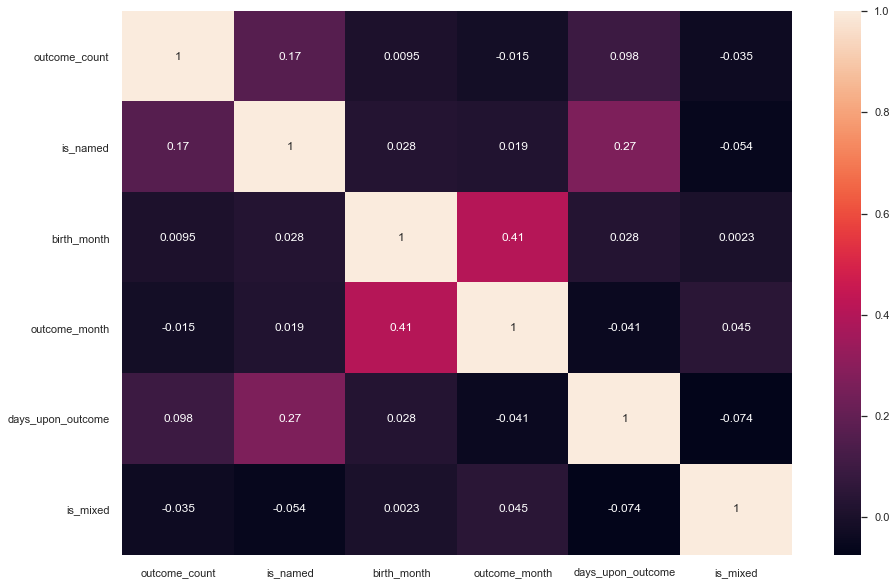

In [61]:
sns.set(rc = ({'figure.figsize':(15, 10)}))
sns.heatmap(data_corr, annot = True, 
            xticklabels = data_corr.columns.values, 
            yticklabels = data_corr.columns.values)

Сильной кореляции между числовыми переменными не наблюдается.

In [168]:
data.profile_report()

Преобразуем категориальные переменные:

In [62]:
data = data.reset_index()

In [63]:
data.drop([ 'index'], axis = 1, inplace = True)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70837 entries, 0 to 70836
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   animal_type        70837 non-null  object
 1   breed              70837 non-null  object
 2   outcome_subtype    70837 non-null  object
 3   outcome_type       70837 non-null  object
 4   outcome_count      70837 non-null  int64 
 5   is_named           70837 non-null  int64 
 6   birth_month        70837 non-null  int64 
 7   outcome_month      70837 non-null  int64 
 8   days_upon_outcome  70837 non-null  int64 
 9   color_1            70837 non-null  object
 10  color_2            70837 non-null  object
 11  is_mixed           70837 non-null  int64 
 12  state              70837 non-null  object
 13  gender             70837 non-null  object
dtypes: int64(6), object(8)
memory usage: 7.6+ MB


Будем использовать LabelEncoder:

In [65]:
label_enc = LabelEncoder()

Для переменной animal_type:

In [66]:
animal_type = label_enc.fit_transform(data['animal_type'])
animal_type = pd.DataFrame(animal_type, columns = ['animal_type'])

Для переменной breed:

In [67]:
breed = label_enc.fit_transform(data['breed'])
breed = pd.DataFrame(breed, columns = ['breed'])

Для переменной outcome_subtype:

In [68]:
outcome_subtype = label_enc.fit_transform(data['outcome_subtype'])
outcome_subtype = pd.DataFrame(outcome_subtype, columns = ['outcome_subtype'])

Для переменной outcome_type:

In [69]:
outcome_type = label_enc.fit_transform(data['outcome_type'])
outcome_type = pd.DataFrame(outcome_type, columns = ['outcome_type'])

Для переменной color_1:

In [70]:
color_1 = label_enc.fit_transform(data['color_1'])
color_1 = pd.DataFrame(color_1, columns = ['color_1'])

Для переменной color_2:

In [71]:
color_2 = label_enc.fit_transform(data['color_2'])
color_2 = pd.DataFrame(color_2, columns = ['color_2'])

Для переменной state:

In [72]:
state = label_enc.fit_transform(data['state'])
state = pd.DataFrame(state, columns = ['state'])

Для переменной gender:

In [73]:
gender = label_enc.fit_transform(data['gender'])
gender = pd.DataFrame(gender, columns = ['gender'])

Создадим новый dataframe, с которым будем работать:

In [74]:
new_data = data[['outcome_count', 'is_named', 'birth_month', 'outcome_month', 'days_upon_outcome', 'is_mixed']]

Объединим преобразованные категориальные переменные с новым набором:

In [75]:
new_data = new_data.join(animal_type)
new_data = new_data.join(breed)
new_data = new_data.join(outcome_subtype)
new_data = new_data.join(outcome_type)
new_data = new_data.join(color_1)
new_data = new_data.join(color_2)
new_data = new_data.join(state)
new_data = new_data.join(gender)

In [76]:
new_data.head(3)

,outcome_count,is_named,birth_month,outcome_month,days_upon_outcome,is_mixed,animal_type,breed,outcome_subtype,outcome_type,color_1,color_2,state,gender
0,1,0,7,7,15,1,1,937,12,8,38,36,0,1
1,1,1,11,11,366,1,2,255,12,8,55,13,2,0
2,1,1,3,6,429,0,2,1610,19,0,7,50,1,1


Перейдем к построению модели. В качестве модели будем использовать случайный лес.

Выделим из датасета тренировочные и тестовые данные. Тренировочные данные будем использовать для обучения модели. Тестовые данные будем использовать для подсчета качества модели.

In [77]:
X = new_data.drop(['outcome_type'], axis = 1)

In [78]:
y = new_data.outcome_type

In [79]:
ros = RandomOverSampler(random_state = 0)

ros.fit(X, y)
x_resampled, y_resampled = ros.fit_sample(X, y)
print('Количество элементов до операции:', len(X))
print('Количество элементов после операции:', len(x_resampled))

Количество элементов до операции: 70837
Количество элементов после операции: 261099


In [80]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)

In [81]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier()

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


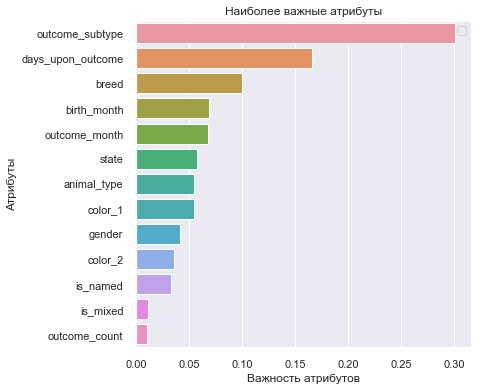

In [82]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Наибольшее влияние на модель оказывают следующие переменные:
1. outcome_subtype;
2. days_upon_outcome;
3. breed;
4. birth_month;
5. outcome_month;
6. state.

Посчитаем качество модели - classification report:

In [83]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      5779
           1       1.00      0.99      0.99      5782
           2       0.99      1.00      0.99      5772
           3       1.00      1.00      1.00      5794
           4       1.00      1.00      1.00      5747
           5       1.00      1.00      1.00      5803
           6       0.86      0.96      0.91      5849
           7       1.00      1.00      1.00      5907
           8       1.00      1.00      1.00      5787

    accuracy                           0.98     52220
   macro avg       0.98      0.98      0.98     52220
weighted avg       0.98      0.98      0.98     52220



0.9764649559555726

Итоговый результат получился неплохим.

Построим вторую модель, в которую включим 6 переменных, оказывающих макисмальное влияние.

In [85]:
X_1 = new_data.drop(['outcome_type', 'outcome_count', 'is_named', 'is_mixed', 'animal_type', 'color_1', 'color_2', 'gender'], axis = 1)

In [86]:
ros = RandomOverSampler(random_state = 0)

ros.fit(X_1, y)
x_resampled, y_resampled = ros.fit_sample(X_1, y)
print('Количество элементов до операции:', len(X_1))
print('Количество элементов после операции:', len(x_resampled))

Количество элементов до операции: 70837
Количество элементов после операции: 261099


In [87]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)

In [88]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier()

In [89]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      5760
           1       1.00      0.98      0.99      5750
           2       0.98      1.00      0.99      5820
           3       1.00      1.00      1.00      5877
           4       1.00      1.00      1.00      5839
           5       1.00      1.00      1.00      5683
           6       0.87      0.95      0.91      5848
           7       1.00      1.00      1.00      5771
           8       1.00      1.00      1.00      5872

    accuracy                           0.98     52220
   macro avg       0.98      0.98      0.98     52220
weighted avg       0.98      0.98      0.98     52220



0.9751436231328993

Результат значительно не поменялся.

Построим модель для меток 0 (Transfer) и 8 (Adoption):

In [99]:
final_data = new_data[(new_data.outcome_type == 0) | (new_data.outcome_type == 8)]

In [102]:
X_2 = final_data.drop(['outcome_type'], axis = 1)

In [103]:
y_2 = final_data.outcome_type

In [104]:
ros = RandomOverSampler(random_state = 0)

ros.fit(X_2, y_2)
x_resampled, y_resampled = ros.fit_sample(X_2, y_2)
print('Количество элементов до операции:', len(X_2))
print('Количество элементов после операции:', len(x_resampled))

Количество элементов до операции: 51971
Количество элементов после операции: 58022


In [106]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)

In [107]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier()

No handles with labels found to put in legend.


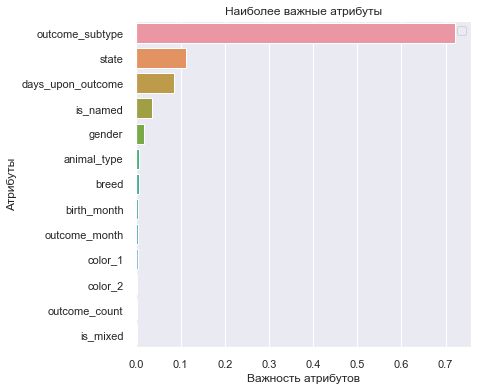

In [108]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Интересно отметить, что для выбранных меток, переменные, оказывающие максимальное влияние, отличаются от значимых переменных для всего набора данных.

In [109]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5859
           8       1.00      1.00      1.00      5746

    accuracy                           1.00     11605
   macro avg       1.00      1.00      1.00     11605
weighted avg       1.00      1.00      1.00     11605



0.9999138302455838

Получился хороший результат :)